# **NONLINEAR ANALYSIS OF A SHALLOW TRUSS**
***

## **Import statements**

This a matter of taste, but we usually tend to do all our `import` statements at the beginning of a session. This practice makes it easy to see the dependencies of a notebook at the get-go, and also helps you to write well organized code.

In [2]:
import numpy as np
from scipy.optimize import newton as Newton, minimize
import matplotlib.pyplot as plt
from time import time

## **Input data**

First, we declare some constants that are assumed to be fixed through the session.
In most cases we are working with only numbers, so it is good practice to explicitly declare the base units that are used, so that other units can be derived from them.

> In this notebook, we are going to use units of $m$ and $kN$.

It is good practice to separate independent parameters (that someone else can or should modify to customize the calculations for the same problem with other dataparameters) and parameters that depend on the independent parameters (and should not be modified). Anyhow, **instructions on how to use your work should be clear and straightforward**.

In [3]:
# INDEPENDENT PARAMETERS - you can modify these
b = 10.  # half of the total width of the structure in [m]
h = 0.5  # initial height of the structure in [m]
EA = 5000.  # <Young's modulus> * <Cross sectional area> in [kN/m2]

# DEPENDENT PARAMETERS - do not modify these
l0 = np.sqrt(h**2 + b**2)  # initial length of a truss member

## **Processing**

We declare two functions, that basically do the same thing. The only difference is the order of the arguments. We will use the fist to run *force-controlled*, and the second to run *displacement-controlled* calculations.

> It's good practice to always write [docstrings](https://www.programiz.com/python-programming/docstrings#:~:text=Python%20docstrings%20are%20the%20string%20literals%20that%20appear,%28%29%20as%20it%20appears%20right%20after%20its%20definition.) for your functions. You might think that you should only do this for a possible audience, but later you will thank me if you get used to writing docstrings.

In [5]:
def R(b, h, EA, k, F):
    """
    Returns the residual for a candidate solution. 
    Optimal for a force-controlled scenario.
    """
    def inner(v):
        l = np.sqrt((h-v)**2 + b**2)
        return F - k*v + EA*((l-l0)/l0)*((h-v)/l0)
    return inner

In [ ]:
def Q(b, h, EA, k, v):
    """
    Returns the residual for a candidate solution. 
    Optimal for a displacement-controlled scenario.
    """
    def inner(F):
        l = np.sqrt((h-v)**2 + b**2)
        return F - k*v + EA*((l-l0)/l0)*((h-v)/l0)
    return inner

We perform an initial calculation. Here we also illustrate two equivalent ways of finding an approximate solution to our problem and a simple way to measure execution time of the two implementations. We're gonna continue working with the one that runs faster.

In [6]:
Fmax = 1.5  # kN
kmax = 1.  # kN/m

# solution by findig roots of a nonlinear function
residual = R(b, h, EA, kmax, Fmax)
t0 = time()
vmax = Newton(residual, 0)
dt_Newton = (time()-t0)*1000
print("Solution by root finding({} ms) : {}".format(dt_Newton, vmax))

# solution by minimizing an error measure
error = lambda x : residual(x[0])**2
t0 = time()
vmax_ = minimize(error, [0], method='Nelder-Mead', tol=1e-8).x[0]
dt_Nelder_Mead = (time()-t0)*1000
print("Solution by minimizing error({} ms) : {}".format(dt_Nelder_Mead, vmax_))

# make a print statement with a one-liner conditional
print("{} is quicker!".format("Newton" if dt_Newton <= dt_Nelder_Mead else "Nelder-Mead"))

Solution by root finding(0.0 ms) : 1.1695310638900063
Solution by minimizing error(3.0007362365722656 ms) : 1.1695310668945325
Newton is quicker!


Here we define convenience functions that run a sequence of analysis for a given spring stiffness. The function `run_F` is for force-controlled calculations, the function `run_D` is for displacement-controlled calculations.

In [936]:
def run_F(k, N=15):
    """
    Convenience function that returns lists of displacements 
    and forces resulting from a force-controlled analysis. 
    The maximum load value `Fmax` is reached in a number of `N` steps.
    """
    f_ext = []
    f_int = []
    disp = []
    v_prev = 0
    for i in range(N):
        Fi = i * Fmax / N
        ri = R(b, h, EA, k, Fi)
        try:
            vi = Newton(ri, v_prev)
            if vi <= vmax:
                li = np.sqrt((h-vi)**2 + b**2)
                Ni = EA * (li-l0)/l0
                f_ext.append(Fi)
                f_int.append(Ni)
                disp.append(vi)
                v_prev = vi
        except:
            pass
    return {'d' : disp, 'f_ext' : f_ext, 'f_int' : f_int}

def run_D(k, N=15):
    """
    Convenience function that returns lists of displacements 
    and forces resulting from a displacement-controlled analysis. 
    The maximum displacement value `vmax` is reached in a number 
    of `N` steps.
    """
    f_ext = []
    f_int = []
    disp = []
    F_prev = 0
    for i in range(N):
        vi = i * vmax / N
        ri = Q(b, h, EA, k, vi)
        try:
            Fi = Newton(ri, F_prev)
            if Fi <= Fmax:
                li = np.sqrt((h-vi)**2 + b**2)
                Ni = EA * (li-l0)/l0
                f_ext.append(Fi)
                f_int.append(Ni)
                disp.append(vi)
                F_prev = Fi
        except:
            pass
    return {'d' : disp, 'f_ext' : f_ext, 'f_int' : f_int}

In [937]:
# a sequence of tuples for springs  containing
# (stiffness, marker, color)
springs = [(1.0, 'o', 'blue'), (0.5, '*', 'green'), (0., '^', 'red')]  
db_F = [run_F(k) for k, *_ in springs]  # force-controlled solutions
db_D = [run_D(k) for k, *_ in springs]  # displacement-controlled solutions

## **Displaying results**

And of course, we do a little plotting. `matplotlib` provides a sea of examples, and we can quickly build a plot with minimal effort.

In [938]:
# dictionary of tick parameters
# For more on customizing matplotlib plots:
# https://matplotlib.org/stable/tutorials/introductory/customizing.html
plotparams = {"xtick.direction" : "inout", "ytick.direction" : "inout",
              "xtick.major.size" : 5, "ytick.major.size" : 5,
              "font.size" : 8}
   
def decorate_ax(ax, legend=True, xlabel=None, ylabel=None):
    # labels, grid and legend
    if xlabel is not None:
        ax.set_xlabel(xlabel)
    if ylabel is not None:
        ax.set_ylabel(ylabel)
    ax.grid(axis='x', lw = 0.5, linestyle='--', color='black')
    ax.grid(axis='y', lw = 0.5, linestyle='--', color='black')
    if legend:
        ax.legend(loc='upper center', fontsize=8)
    
    # spines with arrowheads
    ax.spines['left'].set_color('none')
    ax.spines['bottom'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.spines['right'].set_color('none')
    ax.axvline(x=0, color='black', lw=1)
    ax.axhline(y=0, color='black', lw=1)
    ax.plot((1), (0), ls="", marker=">", ms=5, color="black", 
            transform=ax.get_yaxis_transform(), clip_on=False)
    ax.plot((0), (1), ls="", marker="^", ms=5, color="black", 
            transform=ax.get_xaxis_transform(), clip_on=False)

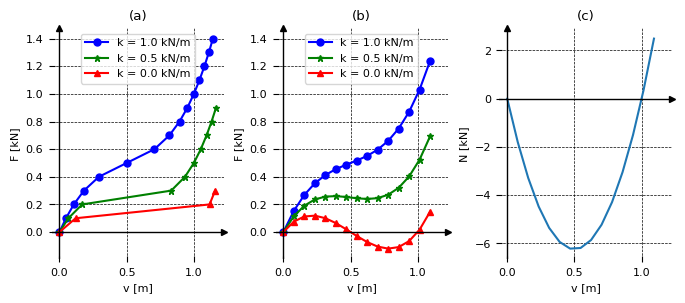

In [940]:
with plt.style.context('default'), plt.rc_context(plotparams):
      # we create teh figure and the plots in advance
      fig = plt.figure(figsize=(8, 3))  # in inches
      
      # force-controlled plots
      ax1 = fig.add_subplot(1, 3, 1)
      for i, (k, m, c) in enumerate(springs):
            label = 'k = {} kN/m'.format(k) 
            ax1.plot(db_F[i]['d'], db_F[i]['f_ext'], label=label, marker=m, markersize=5, color=c)
      ax1.set_title('(a)')
      decorate_ax(ax1, xlabel='v [m]', ylabel='F [kN]')
      
      # displacement-controlled plots
      ax2 = fig.add_subplot(1, 3, 2, sharex=ax1, sharey=ax1)
      for i, (k, m, c) in enumerate(springs):
            label = 'k = {} kN/m'.format(k) 
            ax2.plot(db_D[i]['d'], db_D[i]['f_ext'], label=label, marker=m, markersize=5, color=c)
      ax2.set_title('(b)')
      decorate_ax(ax2, xlabel='v [m]', ylabel='F [kN]')
      
      # internal force
      ax3 = fig.add_subplot(1, 3, 3, sharex=ax1)
      ax3.plot(db_D[0]['d'], db_D[0]['f_int'])
      ax3.set_title('(c)')
      decorate_ax(ax3, legend=False, xlabel='v [m]', ylabel='N [kN]')
            
      # show the plots
      plt.subplots_adjust(wspace=0.3)
      plt.show()